# Importing the necessary libraries

In [40]:
%pip install nibabel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\riddhi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [41]:
%pip install celluloid

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\riddhi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [42]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML

# Accessing the dataset

In [43]:
root = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\3D Liver Segmentation\\imagesTr\\")
label = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\3D Liver Segmentation\\labelsTr\\")

## Appending the labels to the images

In [44]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [45]:
sample_path = list(root.glob("liver*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [46]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata().astype(int)  # Class labels should not be handled as float64

## Deducing the axes

In [47]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

# Animating the CT Slides

<IPython.core.display.Javascript object>


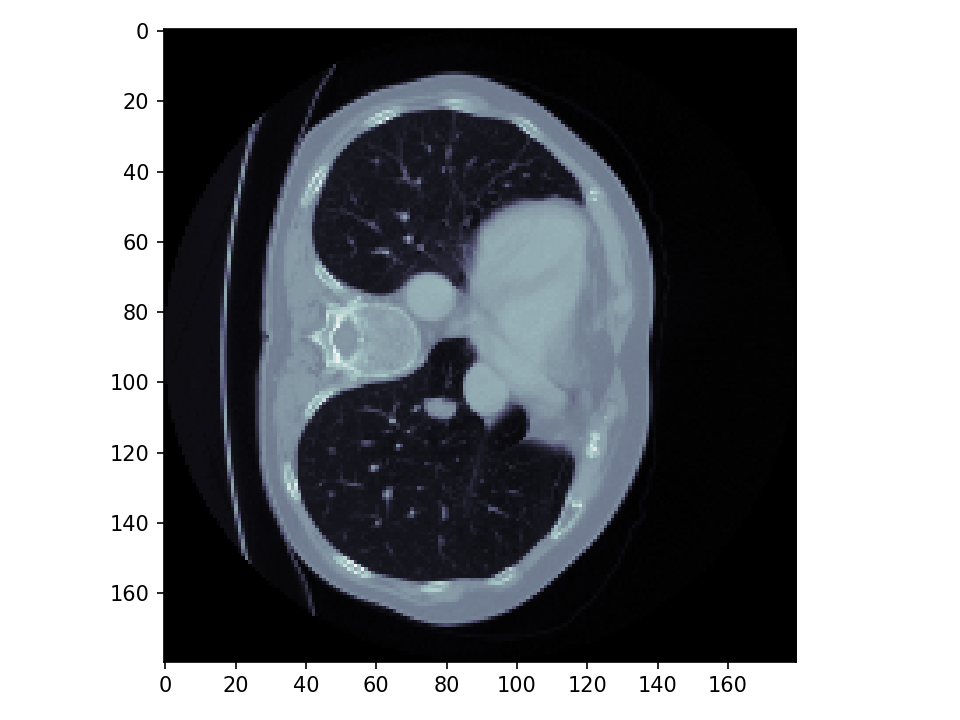

In [48]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(ct.shape[2]):  # Axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5)
    # plt.axis("off")
    camera.snap()  # Store the current slice
plt.tight_layout()
animation = camera.animate()  # Create the animation




In [10]:
HTML(animation.to_html5_video())

# Building the model

In [11]:
import torch

In [12]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv3d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv3d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)


In [13]:

class UNet(torch.nn.Module):
    """
    This class implements a UNet for the Segmentation
    We use 3 down- and 3 UpConvolutions and two Convolutions in each step
    """

    def __init__(self):
        """Sets up the U-Net Structure
        """
        super().__init__()
        
        
        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 32)
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(256 + 128, 128)
        self.layer6 = DoubleConv(128+64, 64)
        self.layer7 = DoubleConv(64+32, 32)
        self.layer8 = torch.nn.Conv3d(32, 3, 1)  # Output: 3 values -> background, liver, tumor
        #########################################

        self.maxpool = torch.nn.MaxPool3d(2)

    def forward(self, x):
        
        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################
        
        ####### DownConv 2#########        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################
        
        ##### Intermediate Layer ## 
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########        
        x5 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x4)  # Upsample with a factor of 2
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########        
        x6 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x5)        
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection    
        x6 = self.layer6(x6)
        ###########################
        
        ####### UpCONV 3#########        
        x7 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)       
        x7 = self.layer7(x7)
        ###########################
        
        ####### Predicted segmentation#########        
        ret = self.layer8(x7)
        return ret

In [14]:
model = UNet()

In [15]:
random_input = torch.randn(1, 1, 128, 128, 128)


In [16]:
with torch.no_grad():
    output = model(random_input)
assert output.shape == torch.Size([1, 3, 128, 128, 128])

In [17]:
pip install torchio

In [18]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

from model import UNet

In [19]:
def change_img_to_label_path(path):
    """
    Replace data with mask to get the masks
    """
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)


In [20]:
path = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\3D Liver Segmentation\\imagesTr\\")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)


In [21]:
for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

In [22]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

In [23]:
train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})
#sampler = tio.data.UniformSampler(patch_size=96)

In [24]:
# Todo: Adapt max_length and num_workers to your hardware

train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )



In [25]:
# TODO, adapt batch size according to your hardware
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)


In [26]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, img, pred, mask, name):
        
        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [27]:
# Instanciate the model
model = Segmenter()

In [28]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [29]:
# Create the trainer
trainer = pl.Trainer(accelerator="cpu", logger=pl.loggers.TensorBoardLogger(save_dir="C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\3D Liver Segmentation\\logs"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback],max_epochs=75, num_sanity_val_steps=0)

In [30]:
# Create the checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\3D Liver Segmentation\\logs',
    monitor='Val Dice',
    save_top_k=10,
    mode='min',
    save_weights_only=True)

# Create the trainer
trainer = pl.Trainer(accelerator="cpu", logger=pl.loggers.TensorBoardLogger(save_dir="C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\3D Liver Segmentation\\logs"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback],max_epochs=75, num_sanity_val_steps=0)

In [ ]:
# Train the model.
# This might take some hours depending on your GPU
trainer.fit(model, train_loader, val_loader)

In [31]:
from IPython.display import HTML
from celluloid import Camera


In [32]:
model = Segmenter.load_from_checkpoint("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\08-3D-Liver-Tumor-Segmentation\\weights\\epoch=97-step=25773.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [33]:
# Select a validation subject and extract the images and segmentation for evaluation
IDX = 4
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

# GridSampler
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))


In [34]:
# GridAggregator
aggregator = tio.inference.GridAggregator(grid_sampler)

In [35]:
# DataLoader for speed up
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

In [36]:
# Prediction
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume
        

In [37]:
# Extract the volume prediction
output_tensor = aggregator.get_output_tensor()  

In [38]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  # axial view
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
    #plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Uncomment if you want to see the label

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [39]:
HTML(animation.to_html5_video())  # convert the animation to a video
